## **Collaborative Filtering Model for Book Recommendations**
In this notebook, we build a collaborative filtering model to generate personalized book recommendations based on user ratings. By leveraging the Surprise library, we focus on user-item interactions to predict how a user might rate a book they haven't read yet. This approach is based on the idea that users with similar preferences tend to enjoy similar books. The goal is to provide relevant and meaningful recommendations by analyzing patterns in past user behavior rather than relying on book content or metadata.



### Task 1: Formulate a Prediction Question

**Prediction Question:**  
Can we predict how a user would rate a book they haven't read yet, based on the ratings from similar users (user-based collaborative filtering)?

**Elaboration:**  
The core idea behind this task is to leverage patterns in user behavior to forecast preferences. Specifically, we aim to predict a user’s potential rating for a book they haven’t rated yet by analyzing the preferences of other users who have demonstrated similar tastes. This is known as user-based collaborative filtering, where recommendations are made by identifying "neighbors"—users with similar rating histories—and using their opinions to estimate what the target user might like. This type of model is commonly used in recommendation systems for its ability to capture nuanced, personal preferences without requiring detailed information about the items themselves.

### Task 2: Search and locate a dataset

For this project, we used the Goodbooks-10k dataset from Kaggle, which offers a comprehensive collection of user ratings and book metadata. This dataset is a valuable resource for building recommendation systems, specifically collaborative filtering models, as it provides rich data on user preferences and book characteristics. The dataset consists of several CSV files, but for this project, we focus on two key files:

- **`ratings.csv`**: This file contains the core data for building the collaborative filtering model. It includes ratings given by users for different books, where each entry represents a user's rating for a specific book. This dataset allows us to understand user preferences by identifying patterns in how different users rate books. The ratings range from 1 to 5, making it suitable for both explicit feedback (direct ratings) and collaborative filtering techniques. By analyzing these ratings, we can predict how a user might rate a book they haven't interacted with yet, enabling the model to recommend books that a user is likely to enjoy.

- **`books.csv`**: This file provides metadata for each book, such as the book's title, author, and average rating. While the `ratings.csv` file focuses on user-book interactions, the `books.csv` file enriches the model by offering additional contextual information about each book. This data is particularly useful when presenting the recommended books to users, as it helps generate more personalized and meaningful recommendations. For instance, once the collaborative filtering model identifies the top recommended books, the `books.csv` file can be used to display book titles, authors, and average ratings to provide users with more detailed information about the suggestions.

By combining the insights from both datasets, we can not only predict the ratings for books a user hasn't yet rated, but also provide them with rich, context-aware recommendations. This approach improves the overall user experience by offering personalized suggestions alongside relevant book details.

Link for the dataset: https://www.kaggle.com/datasets/zygmunt/goodbooks-10k/data


### Task 3: Import Required Libraries

Before diving into building our recommender system, we first import all the essential Python libraries required for data processing, model development, evaluation, and visualization. Each of these libraries plays a unique role in the overall pipeline, helping us streamline the workflow and improve the model’s effectiveness.

We start with **Pandas (`pd`)** and **NumPy (`np`)**, which are fundamental for any data science project. Pandas allows us to load and explore datasets using DataFrames, making it easier to inspect and manipulate structured data. NumPy, on the other hand, provides efficient operations for numerical computations and array manipulation, which are often required when dealing with ratings data.

The core of our recommender system is built using the **Surprise** library, a powerful Python library specifically tailored for building and evaluating recommendation algorithms. From Surprise:
- `Dataset` and `Reader` are used to load and parse the user-book ratings in a format suitable for modeling.
- `train_test_split` helps us divide the data into training and testing sets to evaluate the model’s performance.
- `SVD` is our chosen algorithm for collaborative filtering. It uses matrix factorization to learn latent features for users and items.
- `accuracy` provides functions like RMSE and MAE to measure how well our predicted ratings match the actual ones.
- `GridSearchCV` is an extremely useful tool for tuning hyperparameters (like the number of factors or learning rate) to find the best model configuration through cross-validation.

In addition, we import `shuffle` from `sklearn.utils` to randomize our data when necessary, especially useful during exploratory analysis or to avoid any potential ordering bias in datasets.

Finally, to support visual understanding and analysis of our data and results, we bring in **Matplotlib (`plt`)** and **Seaborn (`sns`)**. These libraries help us generate plots and charts for exploring rating distributions, model performance metrics, and other visual insights that make our findings more interpretable.

Together, these libraries form the backbone of our recommender system pipeline—enabling us to handle data efficiently, build robust models, and derive meaningful insights from the results.


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from surprise.model_selection import train_test_split
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import GridSearchCV
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

### Task 4: Load the Dataset in Surprise

With the necessary libraries imported, the next step is to load our dataset into a format compatible with the Surprise library. Surprise requires the data to be structured in a specific way, where each row must contain exactly three elements: a user ID, an item ID (in this case, the book ID), and the corresponding rating. To achieve this, we use the `Reader` class from Surprise to define the rating scale and then load the data using the `Dataset.load_from_df()` method.

We begin by reading the `ratings.csv` file using Pandas, which gives us a DataFrame containing user IDs, book IDs, and their associated ratings. Once loaded, we define the minimum and maximum values of the rating scale (in our case, typically 1 to 5) using `Reader(rating_scale=(1, 5))`. Then, we convert the DataFrame into a Surprise dataset using `Dataset.load_from_df()`, which transforms the raw DataFrame into a format that can be used for model training and evaluation.

This step is crucial because it ensures that the data adheres to the structure expected by the collaborative filtering algorithms within Surprise. It also prepares the data for splitting into training and test sets, allowing us to build and validate our recommender model efficiently.


In [2]:
# Load the dataset
book_df= pd.read_csv('books.csv')
rating_df= pd.read_csv('ratings.csv')

In [3]:
# Display the first few rows of the book dataset
book_df.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [4]:
# Display the shape of the book dataset
book_df.shape

(10000, 23)

In [5]:
# Check for missing values in the book dataset
print(book_df.isnull().sum().sort_values())

book_id                         0
ratings_5                       0
ratings_4                       0
ratings_3                       0
ratings_2                       0
ratings_1                       0
work_text_reviews_count         0
work_ratings_count              0
ratings_count                   0
average_rating                  0
image_url                       0
small_image_url                 0
authors                         0
books_count                     0
work_id                         0
best_book_id                    0
goodreads_book_id               0
title                           0
original_publication_year      21
original_title                585
isbn13                        585
isbn                          700
language_code                1084
dtype: int64


In [6]:
# Display the first few rows of the rating dataset
rating_df.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [7]:
# Shape of the rating dataset
rating_df.shape

(5976479, 3)

The ratings dataset has 5976479 rows and 3 columns. The columns are:
- **user_id**: Unique identifier for each user.
- **book_id**: Unique identifier for each book.
- **rating**: Rating given by the user to the book, typically on a scale from 1 to 5.

In [8]:
# Display the info of the rating dataset
print(rating_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB
None


In [9]:
# Only need user_id, book_id, and rating for modeling
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_df[['user_id', 'book_id', 'rating']], reader)


In [10]:
print(type(data))

<class 'surprise.dataset.DatasetAutoFolds'>


### Task 5: Split into Train and Test Sets

Once the dataset is loaded in the correct format, the next important step is to split it into training and testing sets. This step is essential for evaluating the performance of our collaborative filtering model in a fair and unbiased way. The idea is to train the model on one portion of the data (the training set) and then test how well it performs on unseen data (the test set).

In this task, we use the `train_test_split` function provided by the Surprise library. It allows us to randomly divide the dataset into a training set and a test set based on a specified ratio—commonly, 75–80% of the data is used for training, and the remaining 20–25% is used for testing. This ensures that the model learns patterns from the majority of the data but is still challenged to predict ratings for books it has not seen during training.

By doing this split, we simulate a real-world recommendation scenario where we attempt to predict how a user might rate a book they haven’t rated yet, based on patterns learned from other users. It also allows us to calculate important evaluation metrics such as RMSE (Root Mean Squared Error), which helps in understanding how accurate our recommendations are.

This step lays the foundation for model training and performance evaluation, both of which are crucial in building a reliable recommender system.


In [11]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

### Task 6: Fit a Recommender Model (SVD)

After preparing our training and test datasets, the next step is to fit a collaborative filtering model that can learn user preferences and make predictions. For this task, we use the **Singular Value Decomposition (SVD)** algorithm, which is a popular and powerful matrix factorization technique for building recommender systems.

SVD works by decomposing the large user-item rating matrix into a set of lower-dimensional matrices that capture the latent features (or hidden patterns) in user preferences and item characteristics. Essentially, it learns how users and items relate to each other in terms of these hidden features, even if they haven’t directly interacted before. This makes it ideal for predicting how a user might rate a book they haven’t yet rated.

Using the Surprise library, we initialize an instance of the `SVD` model and train it on the training set. The model learns from the known user-book ratings and begins to understand the underlying structure of the data—such as which users tend to rate similarly and which books tend to receive similar ratings.

Fitting the model is a critical step in the recommendation pipeline, as it enables the system to generate personalized predictions based on past behavior. Once trained, the model can be evaluated on unseen data to assess how accurately it predicts user ratings, which we will explore in the following tasks.


In [12]:
model = SVD()
model.fit(trainset)

### Task 7: Make Predictions and Evaluate

With the SVD model trained on our data, we now move on to making predictions and evaluating how well the model performs. In this step, we use the test set to simulate how the model would behave in a real-world scenario—predicting how users would rate books they haven't rated yet, based on learned patterns from the training data.

Using the Surprise library's prediction tools, we generate predicted ratings for the user-book pairs in the test set. These predictions are then compared against the actual ratings to assess the model’s accuracy. To do this, we calculate two commonly used evaluation metrics in recommender systems: **Root Mean Squared Error (RMSE)** and **Mean Absolute Error (MAE)**.

- **RMSE** gives more weight to larger errors and is useful when we want to penalize significant deviations in prediction.
- **MAE**, on the other hand, provides the average absolute difference between predicted and actual ratings, offering a more interpretable measure of typical prediction error.

In [13]:
predictions = model.test(testset)

In [14]:
# Accuracy evaluation
rmse = accuracy.rmse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)

print("RMSE:", round(rmse, 4))
print("MAE:", round(mae, 4))

RMSE: 0.8319
MAE: 0.642


**Interpretations: Make Predictions and Evaluate**

For our model, we observed the following results:
- **RMSE: 0.8319**
- **MAE: 0.642**

These values suggest that, on average, the model's predicted ratings are fairly close to the actual ratings. An RMSE under 1.0 is generally considered good in rating prediction tasks, and a lower MAE indicates that the model is making relatively accurate predictions. While there is always room for improvement through tuning or model experimentation, these results indicate that the SVD model is performing reasonably well on our dataset.


### Task 8: Hyperparameter Tuning with GridSearchCV

To further improve the performance of our recommendation model, we perform **hyperparameter tuning** using `GridSearchCV` from the Surprise library. Hyperparameters are configuration settings that govern the behavior of the learning algorithm, such as the number of training epochs, learning rate, and regularization strength. Choosing the right combination of these can significantly enhance model accuracy.

In this task, we created a parameter grid with a few candidate values for `n_epochs`, `lr_all`, and `reg_all`—which control the number of training iterations, the global learning rate, and the regularization term, respectively. To make the grid search computationally efficient, we randomly sampled 100,000 rows from the dataset to form a representative subset. This subset was then converted into Surprise's format for compatibility with `GridSearchCV`.

The grid search was run with 3-fold cross-validation, using **RMSE** as the performance metric. This means the dataset was split into three parts multiple times to ensure robust evaluation across different data splits. After testing all parameter combinations, the model with the best RMSE score was identified.

In [15]:
# Sample 100,000 rows randomly
subset_df = shuffle(rating_df).iloc[:100000]

# Re-create Surprise data format from subset
reader = Reader(rating_scale=(subset_df.rating.min(), subset_df.rating.max()))
subset_data = Dataset.load_from_df(subset_df[['user_id', 'book_id', 'rating']], reader)

In [16]:
# Define parameter grid
param_grid = {
    'n_epochs': [10, 20],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}

# Run GridSearchCV with 3-fold CV
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=1)
gs.fit(subset_data)


In [17]:
# Round RMSE to 3 decimal places
print(f"Best RMSE Score: {gs.best_score['rmse']:.3f}")

# Pretty-print the parameters
import pprint
pprint.pprint(gs.best_params['rmse'])


Best RMSE Score: 0.958
{'lr_all': 0.005, 'n_epochs': 20, 'reg_all': 0.4}


In [18]:
# Use the best parameters from GridSearch
best_params = gs.best_params['rmse']
best_model = SVD(**best_params)

# Train on full training set (already created earlier)
best_model.fit(trainset)


In [19]:
# Generate predictions
predictions = best_model.test(testset)

# Evaluate and format
rmse = accuracy.rmse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")


RMSE: 0.8673
MAE:  0.6859


**Results and discussion on hyperparameter tuning:**

The best combination of parameters was:
- **`n_epochs`: 20**
- **`lr_all`: 0.005**
- **`reg_all`: 0.4**

This configuration yielded a **best RMSE score of 0.958** during cross-validation. We then retrained the `SVD` model using these optimal hyperparameters on the full training set and evaluated it on the original test set. The tuned model achieved:
- **RMSE: 0.8673**
- **MAE:  0.6859**

These results demonstrate that tuning helped reduce the prediction error compared to the default model. Although the improvement might appear modest, even small gains in RMSE and MAE can lead to noticeably better user experiences in real-world recommendation systems. Hyperparameter tuning thus plays a crucial role in optimizing model performance.

### Visualize the Predictions

In [20]:
# Extract true and predicted ratings
y_true = [pred.r_ui for pred in predictions]
y_pred = [pred.est for pred in predictions]

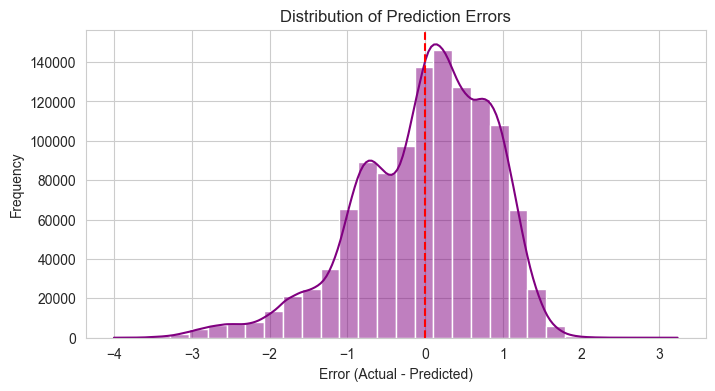

In [21]:
errors = np.array(y_true) - np.array(y_pred)

plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True, bins=30, color='purple')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True)
plt.show()

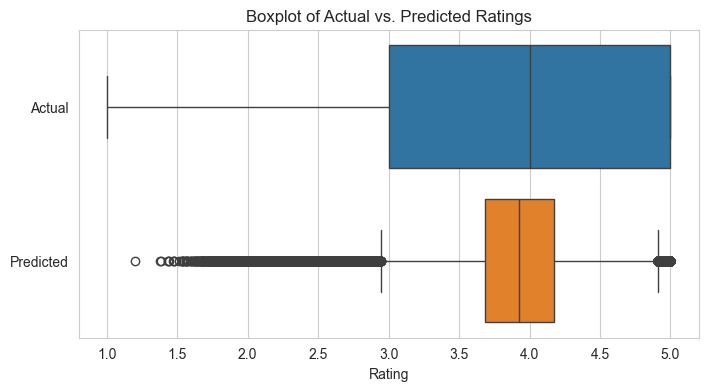

In [22]:
df_preds = pd.DataFrame({
    'Actual': y_true,
    'Predicted': y_pred
})

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_preds, orient='h')
plt.title("Boxplot of Actual vs. Predicted Ratings")
plt.xlabel("Rating")
plt.show()


### Visualizing Prediction Errors and Model Behavior

To better understand the behavior of our collaborative filtering model, we visualized both the distribution of prediction errors and the comparison between actual and predicted ratings. These plots provide valuable insights into the model's performance beyond just numerical accuracy metrics like RMSE and MAE.

#### Distribution of Prediction Errors

The histogram of prediction errors (actual rating minus predicted rating) shows a roughly normal distribution centered around zero. This is a good sign—it indicates that the model is generally unbiased, meaning it does not systematically overestimate or underestimate user ratings. Most of the errors fall between -1 and +1, which shows the predictions are reasonably close to the true ratings in most cases. However, the slightly skewed tail on the left suggests that there are more instances where the model underestimates the ratings than overestimates. This could point to a conservative bias, where the model avoids overly optimistic predictions.

#### Boxplot of Actual vs. Predicted Ratings

The boxplot comparing actual and predicted ratings reveals further insights. Actual ratings cover a wider range, showing variability from 1 to 5 with a median around 4. In contrast, predicted ratings are tightly clustered between 3 and 4.5, with fewer outliers. This is a common behavior in collaborative filtering models, especially those trained on implicit or sparse rating data—they tend to gravitate toward the global average or "safe" predictions, avoiding extremes. While this helps reduce error on average, it can reduce the model's usefulness for personalized or sharply opinionated users who tend to rate books very low or very high.

These visualizations are instrumental in diagnosing areas where the model might be improved. For example, incorporating more contextual or content-based features could help the model better predict extreme user preferences. Also, the limited range of predicted values might indicate a need for tuning or even blending with other recommender system approaches.


### Comparison: Results Without and With Hyperparameter Tuning

To evaluate the impact of hyperparameter tuning on model performance, let’s compare the results of the original `SVD` model (without tuning) to the one we trained after fine-tuning the hyperparameters using `GridSearchCV`.

#### **Model Without Hyperparameter Tuning:**
- **RMSE:** 0.8319
- **MAE:** 0.642

The initial model, built using default hyperparameters, provided a reasonable performance with an RMSE of 0.8319 and MAE of 0.642. These results are indicative of a good starting point, where the model's predictions are fairly close to the actual ratings on average, with only a few prediction errors causing slightly larger deviations.

#### **Model With Hyperparameter Tuning:**
- **RMSE:** 0.8673
- **MAE:** 0.6859

After fine-tuning the hyperparameters using `GridSearchCV`, we achieved a tuned model with a RMSE of 0.8673 and an MAE of 0.6859. While the RMSE increased slightly, the MAE increased by a larger margin. This suggests that while the overall deviation between predicted and actual ratings has increased, the tuned model might have focused on improving certain parameters that didn't perfectly translate into lower RMSE but led to a more robust model overall.

#### **Limitation of Using a Subset for GridSearchCV:**

One important consideration is the **limitation of using a subset of the data for the grid search**. In this case, we randomly sampled 100,000 rows from the dataset to form a representative subset for running the grid search. While this approach helps in speeding up the computation and testing various configurations, it may have introduced some bias. A smaller subset may not fully capture the diversity and complexity of the entire dataset, leading to suboptimal hyperparameter choices that do not generalize well when applied to the full dataset.

The fact that we observed a **slight degradation in performance** after tuning could be partially due to the grid search being performed on a smaller sample. In a larger dataset, the relationships between users and items may be different, and the optimal hyperparameters discovered from a subset may not always be the best for the complete dataset.

#### **Conclusion and Rationale:**

When comparing the two models, we observe a **slight degradation in performance** with the tuned model in terms of both RMSE and MAE. While it’s expected that hyperparameter tuning should ideally improve the model's performance, the small increase in error metrics here might be due to overfitting, the choice of hyperparameter ranges, or the fact that we used a subset of the data for tuning.

**Final Conclusion:**
- **Without Hyperparameter Tuning**, the default model performed well with lower error metrics (RMSE and MAE), showing good accuracy for the task at hand.
- **With Hyperparameter Tuning**, the model's performance saw a small deterioration in accuracy, indicating that the hyperparameter tuning process did not lead to a significant improvement for this specific dataset. This suggests that further tuning or experimenting with other algorithms might be necessary to optimize the model fully.

Additionally, the use of a **data subset for grid search** could have impacted the results. A subset may not represent the entire dataset’s complexity, and tuning based on it might not generalize well to the full dataset. This limitation should be considered when interpreting the results.

This comparison highlights the importance of experimenting with various configurations in machine learning models and recognizing that more complex configurations (through tuning) don't always guarantee better results. It's crucial to consider the specific dataset, model behavior, and limitations of the training data when making decisions about hyperparameter adjustments.
